In [30]:
# Cell [1]
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import nibabel as nib

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [31]:
# Cell [2]
# ============================================================================
# DATASET CONFIGURATION
# ============================================================================

# Update this path to your CAMUS dataset location
CAMUS_ROOT = "database_nifti"  # Update if needed

# Verify path exists
if os.path.exists(CAMUS_ROOT):
    print(f"✓ CAMUS dataset found at: {CAMUS_ROOT}")
    patients = [d for d in os.listdir(CAMUS_ROOT) if d.startswith("patient")]
    print(f"✓ Found {len(patients)} patients")
else:
    print(f"✗ Path not found: {CAMUS_ROOT}")
    print("Please update CAMUS_ROOT to your dataset location")

✓ CAMUS dataset found at: database_nifti
✓ Found 500 patients


In [32]:
# Cell [3]
# ============================================================================
# DATA LOADING FUNCTIONS (NIfTI FORMAT)
# ============================================================================

def load_camus_image(patient_id, view, phase):
    """
    Load a CAMUS image from NIfTI format.
    
    Args:
        patient_id: e.g., "0001"
        view: "2CH" or "4CH"
        phase: "ED" or "ES"
    
    Returns:
        numpy array of the image
    """
    patient_dir = os.path.join(CAMUS_ROOT, f"patient{patient_id}")
    filename = f"patient{patient_id}_{view}_{phase}.nii.gz"
    filepath = os.path.join(patient_dir, filename)
    
    if os.path.exists(filepath):
        nii = nib.load(filepath)
        data = nii.get_fdata()
        # NIfTI images are 3D, take first slice for 2D echo
        if data.ndim == 3:
            data = data[:, :, 0]
        return data
    else:
        print(f"File not found: {filepath}")
        return None

def load_camus_gt(patient_id, view, phase):
    """
    Load CAMUS ground truth segmentation from NIfTI format.
    
    Returns:
        numpy array with segmentation labels (0=background, 1=LV, 2=MYO, 3=LA)
    """
    patient_dir = os.path.join(CAMUS_ROOT, f"patient{patient_id}")
    filename = f"patient{patient_id}_{view}_{phase}_gt.nii.gz"
    filepath = os.path.join(patient_dir, filename)
    
    if os.path.exists(filepath):
        nii = nib.load(filepath)
        data = nii.get_fdata()
        # NIfTI images are 3D, take first slice for 2D echo
        if data.ndim == 3:
            data = data[:, :, 0]
        return data.astype(np.uint8)
    else:
        print(f"GT file not found: {filepath}")
        return None

def load_patient_info(patient_id, view="2CH"):
    """Load patient clinical information from Info_*.cfg"""
    patient_dir = os.path.join(CAMUS_ROOT, f"patient{patient_id}")
    info_file = os.path.join(patient_dir, f"Info_{view}.cfg")
    
    info = {}
    if os.path.exists(info_file):
        with open(info_file, 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.strip().split(':', 1)
                    info[key.strip()] = value.strip()
    
    return info

In [33]:
# Cell [4]
# ============================================================================
# SEGMENTATION EXTRACTION FUNCTIONS
# ============================================================================

def get_lv_mask(patient_id, view, phase, source="gt"):
    """
    Extract left ventricle cavity mask.
    
    Args:
        source: "gt" for ground truth, "pred" for predictions (if available)
    
    Returns:
        Binary mask of LV cavity (label 1)
    """
    if source == "gt":
        seg = load_camus_gt(patient_id, view, phase)
    else:
        # Placeholder for predictions
        seg = None
    
    if seg is not None:
        return (seg == 1).astype(np.uint8)
    return None

def get_myo_mask(patient_id, view, phase, source="gt"):
    """Extract myocardium mask (label 2)"""
    if source == "gt":
        seg = load_camus_gt(patient_id, view, phase)
    else:
        seg = None
    
    if seg is not None:
        return (seg == 2).astype(np.uint8)
    return None

def get_la_mask(patient_id, view, phase, source="gt"):
    """Extract left atrium mask (label 3)"""
    if source == "gt":
        seg = load_camus_gt(patient_id, view, phase)
    else:
        seg = None
    
    if seg is not None:
        return (seg == 3).astype(np.uint8)
    return None

In [34]:
# Cell [5]
# ============================================================================
# PIXEL SPACING EXTRACTION
# ============================================================================

def get_pixel_spacing(patient_id, view, phase):
    """
    Extract pixel spacing from NIfTI header.
    
    Returns:
        Tuple of (spacing_x, spacing_y) in mm
    """
    patient_dir = os.path.join(CAMUS_ROOT, f"patient{patient_id}")
    filename = f"patient{patient_id}_{view}_{phase}.nii.gz"
    filepath = os.path.join(patient_dir, filename)
    
    if os.path.exists(filepath):
        nii = nib.load(filepath)
        # Get pixel dimensions from header
        pixdim = nii.header['pixdim'][1:3]  # First two spatial dimensions
        return pixdim[0], pixdim[1]
    else:
        # Default fallback
        return 0.308, 0.308

In [35]:
# Cell [6]
# ============================================================================
# AREA CALCULATION FUNCTIONS
# ============================================================================

def lv_area_mm2(patient_id, view, phase, source="gt"):
    """
    Calculate LV cavity area in mm².
    """
    mask = get_lv_mask(patient_id, view, phase, source)
    
    if mask is None:
        return None
    
    # Get pixel spacing
    spacing_x, spacing_y = get_pixel_spacing(patient_id, view, phase)
    
    # Pixel area count
    pixel_area = np.sum(mask)
    
    # Convert to mm²
    area_mm2 = pixel_area * spacing_x * spacing_y
    
    return area_mm2

def myo_area_mm2(patient_id, view, phase, source="gt"):
    """Calculate myocardium area in mm²"""
    mask = get_myo_mask(patient_id, view, phase, source)
    
    if mask is None:
        return None
    
    spacing_x, spacing_y = get_pixel_spacing(patient_id, view, phase)
    pixel_area = np.sum(mask)
    area_mm2 = pixel_area * spacing_x * spacing_y
    
    return area_mm2

In [36]:
# Cell [7]
# ============================================================================
# VOLUME CALCULATION (AREA-LENGTH METHOD)
# ============================================================================

def calculate_lv_volume_al(area_mm2, length_mm):
    """
    Area-Length method for volume calculation.
    
    V = (8/3π) × A² / L
    
    Args:
        area_mm2: LV cavity area in mm²
        length_mm: LV length from apex to mitral valve in mm
    
    Returns:
        Volume in mL
    """
    if area_mm2 is None or length_mm is None or length_mm == 0:
        return None
    
    volume_mm3 = (8 / (3 * np.pi)) * (area_mm2 ** 2) / length_mm
    volume_ml = volume_mm3 / 1000  # Convert mm³ to mL
    
    return volume_ml

def estimate_lv_length(mask, pixel_spacing_x=0.308, pixel_spacing_y=0.308):
    """
    Estimate LV length from apex to base.
    Simple approximation: maximum vertical extent of mask.
    """
    if mask is None or np.sum(mask) == 0:
        return None
    
    rows, cols = np.where(mask > 0)
    length_pixels = np.max(rows) - np.min(rows)
    length_mm = length_pixels * pixel_spacing_y
    
    return length_mm

In [37]:
# Cell [8]
# ============================================================================
# COMPLETE VOLUME CALCULATIONS
# ============================================================================

def calculate_volumes(patient_id, view, source="gt"):
    """
    Calculate EDV, ESV, SV, and EF for a given view.
    
    Returns:
        dict with 'EDV', 'ESV', 'SV', 'EF' in mL and %
    """
    # Get ED and ES masks
    mask_ed = get_lv_mask(patient_id, view, "ED", source)
    mask_es = get_lv_mask(patient_id, view, "ES", source)
    
    if mask_ed is None or mask_es is None:
        return None
    
    # Get pixel spacing
    spacing_x, spacing_y = get_pixel_spacing(patient_id, view, "ED")
    
    # Calculate areas
    area_ed = lv_area_mm2(patient_id, view, "ED", source)
    area_es = lv_area_mm2(patient_id, view, "ES", source)
    
    # Estimate lengths
    length_ed = estimate_lv_length(mask_ed, spacing_x, spacing_y)
    length_es = estimate_lv_length(mask_es, spacing_x, spacing_y)
    
    # Calculate volumes
    edv = calculate_lv_volume_al(area_ed, length_ed)
    esv = calculate_lv_volume_al(area_es, length_es)
    
    if edv is None or esv is None or edv == 0:
        return None
    
    # Stroke volume and ejection fraction
    sv = edv - esv
    ef = (sv / edv) * 100
    
    return {
        'EDV': edv,
        'ESV': esv,
        'SV': sv,
        'EF': ef
    }

def calculate_biplane_volumes(patient_id, source="gt"):
    """
    Calculate volumes using Simpson's biplane method (2CH + 4CH).
    Average the two views.
    """
    vols_2ch = calculate_volumes(patient_id, "2CH", source)
    vols_4ch = calculate_volumes(patient_id, "4CH", source)
    
    if vols_2ch is None or vols_4ch is None:
        return None
    
    # Average the two views
    edv = (vols_2ch['EDV'] + vols_4ch['EDV']) / 2
    esv = (vols_2ch['ESV'] + vols_4ch['ESV']) / 2
    sv = edv - esv
    ef = (sv / edv) * 100 if edv > 0 else 0
    
    return {
        'EDV': edv,
        'ESV': esv,
        'SV': sv,
        'EF': ef
    }

In [38]:
# Cell [9]
# ============================================================================
# SIMPLE VISUALIZATION TEST
# ============================================================================

def quick_view(patient_id, view="2CH", phase="ED"):
    """Quick visualization of one image with segmentation"""
    
    img = load_camus_image(patient_id, view, phase)
    seg = load_camus_gt(patient_id, view, phase)
    
    if img is None or seg is None:
        print("Could not load image or segmentation")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Segmentation
    axes[1].imshow(seg, cmap='jet')
    axes[1].set_title('Segmentation (0=BG, 1=LV, 2=MYO, 3=LA)')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(seg, alpha=0.4, cmap='jet')
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.suptitle(f'Patient {patient_id} - {view} - {phase}')
    plt.tight_layout()
    plt.show()
    
    # Print info
    area = lv_area_mm2(patient_id, view, phase)
    print(f"LV Area: {area:.1f} mm²" if area else "LV Area: N/A")

In [39]:
# Cell [10]
# ============================================================================
# TEST DATA LOADING
# ============================================================================

# Test loading for patient 0001
print("Testing data loading for patient 0001...\n")

test_pid = "0001"

# Try to load images
for view in ["2CH", "4CH"]:
    for phase in ["ED", "ES"]:
        img = load_camus_image(test_pid, view, phase)
        seg = load_camus_gt(test_pid, view, phase)
        
        status_img = "✓" if img is not None else "✗"
        status_seg = "✓" if seg is not None else "✗"
        
        print(f"{status_img} Image {view} {phase}: {img.shape if img is not None else 'Not found'}")
        print(f"{status_seg} Seg   {view} {phase}: {seg.shape if seg is not None else 'Not found'}")

# Load patient info
info = load_patient_info(test_pid)
if info:
    print(f"\nPatient Info:")
    for key, value in info.items():
        print(f"  {key}: {value}")

Testing data loading for patient 0001...

✓ Image 2CH ED: (549, 389)
✓ Seg   2CH ED: (549, 389)
✓ Image 2CH ES: (549, 389)
✓ Seg   2CH ES: (549, 389)
✓ Image 4CH ED: (549, 389)
✓ Seg   4CH ED: (549, 389)
✓ Image 4CH ES: (549, 389)
✓ Seg   4CH ES: (549, 389)

Patient Info:
  ED: 1
  ES: 18
  NbFrame: 18
  Sex: F
  Age: 56
  ImageQuality: Good
  EF: 54
  FrameRate: 48.4


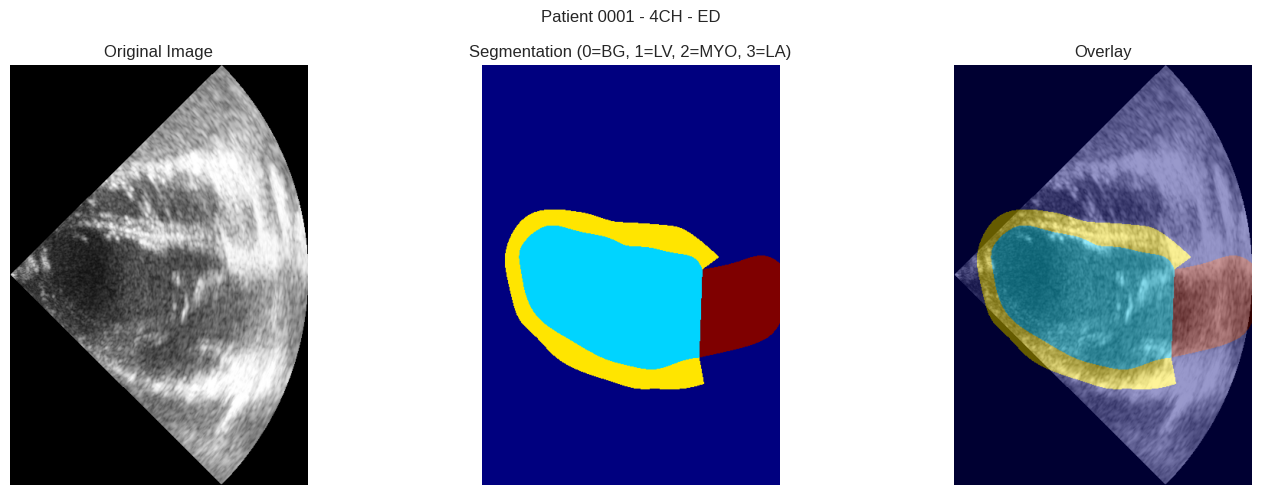

LV Area: 3167.9 mm²


In [40]:
# Cell [11]
# ============================================================================
# QUICK VISUALIZATION TEST
# ============================================================================

# Visualize one example
quick_view("0001", "4CH", "ED")

In [42]:
# Cell [12]
# ============================================================================
# COMPLETE VISUALIZATION FUNCTION
# ============================================================================

def visualize_camus_analysis(pid, source="gt"):
    """Complete visualization of CAMUS patient analysis"""
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)
    
    # Row 1 & 2: Images with segmentation overlays
    views = ["2CH", "4CH"]
    phases = ["ED", "ES"]
    
    for i, view in enumerate(views):
        for j, phase in enumerate(phases):
            ax = fig.add_subplot(gs[i, j])
            
            img = load_camus_image(pid, view, phase)
            mask = get_lv_mask(pid, view, phase, source)
            
            if img is not None:
                ax.imshow(img, cmap='gray')
                
                if mask is not None:
                    ax.imshow(mask, alpha=0.4, cmap='Reds')
                
                # Add measurements
                area = lv_area_mm2(pid, view, phase, source)
                if area:
                    ax.text(0.02, 0.98, f"Area: {area:.0f} mm²", 
                           transform=ax.transAxes, fontsize=10,
                           verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='white', alpha=0.8))
                
                ax.set_title(f"{view} - {phase}", fontsize=12, fontweight='bold')
                ax.axis('off')
    
    # Row 3: Volume and EF plots
    ax_vol = fig.add_subplot(gs[2, :2])
    ax_ef = fig.add_subplot(gs[2, 2:])
    
    # Volume comparison
    volumes_2ch = calculate_volumes(pid, "2CH", source)
    volumes_4ch = calculate_volumes(pid, "4CH", source)
    
    if volumes_2ch and volumes_4ch:
        views_data = ['2CH', '4CH']
        ed_vols = [volumes_2ch['EDV'], volumes_4ch['EDV']]
        es_vols = [volumes_2ch['ESV'], volumes_4ch['ESV']]
        
        x = np.arange(len(views_data))
        width = 0.35
        
        ax_vol.bar(x - width/2, ed_vols, width, label='EDV', color='#2ecc71')
        ax_vol.bar(x + width/2, es_vols, width, label='ESV', color='#e74c3c')
        
        ax_vol.set_ylabel('Volume (mL)', fontsize=11)
        ax_vol.set_title('LV Volumes by View', fontsize=12, fontweight='bold')
        ax_vol.set_xticks(x)
        ax_vol.set_xticklabels(views_data)
        ax_vol.legend()
        ax_vol.grid(axis='y', alpha=0.3)
        
        # Ejection Fraction
        efs = [volumes_2ch['EF'], volumes_4ch['EF']]
        
        ax_ef.bar(views_data, efs, color='#3498db', alpha=0.7)
        ax_ef.axhline(y=50, color='r', linestyle='--', label='Normal threshold (50%)')
        ax_ef.set_ylabel('Ejection Fraction (%)', fontsize=11)
        ax_ef.set_title('Ejection Fraction by View', fontsize=12, fontweight='bold')
        ax_ef.set_ylim(0, 100)
        ax_ef.legend()
        ax_ef.grid(axis='y', alpha=0.3)
    
    plt.suptitle(f'CAMUS Patient {pid} - Cardiac Analysis ({source.upper()})', 
                 fontsize=14, fontweight='bold')
    plt.show()
    
    # Print numerical summary
    print(f"\n{'='*60}")
    print(f"Patient {pid} - Quantitative Analysis Summary")
    print(f"{'='*60}")
    
    for view in ["2CH", "4CH"]:
        vols = calculate_volumes(pid, view, source)
        if vols:
            print(f"\n{view} View:")
            print(f"  EDV: {vols['EDV']:.1f} mL")
            print(f"  ESV: {vols['ESV']:.1f} mL")
            print(f"  SV:  {vols['SV']:.1f} mL")
            print(f"  EF:  {vols['EF']:.1f} %")
    
    # Biplane average
    biplane = calculate_biplane_volumes(pid, source)
    if biplane:
        print(f"\nBiplane Average:")
        print(f"  EDV: {biplane['EDV']:.1f} mL")
        print(f"  ESV: {biplane['ESV']:.1f} mL")
        print(f"  SV:  {biplane['SV']:.1f} mL")
        print(f"  EF:  {biplane['EF']:.1f} %")
    
    print(f"\n{'='*60}\n")

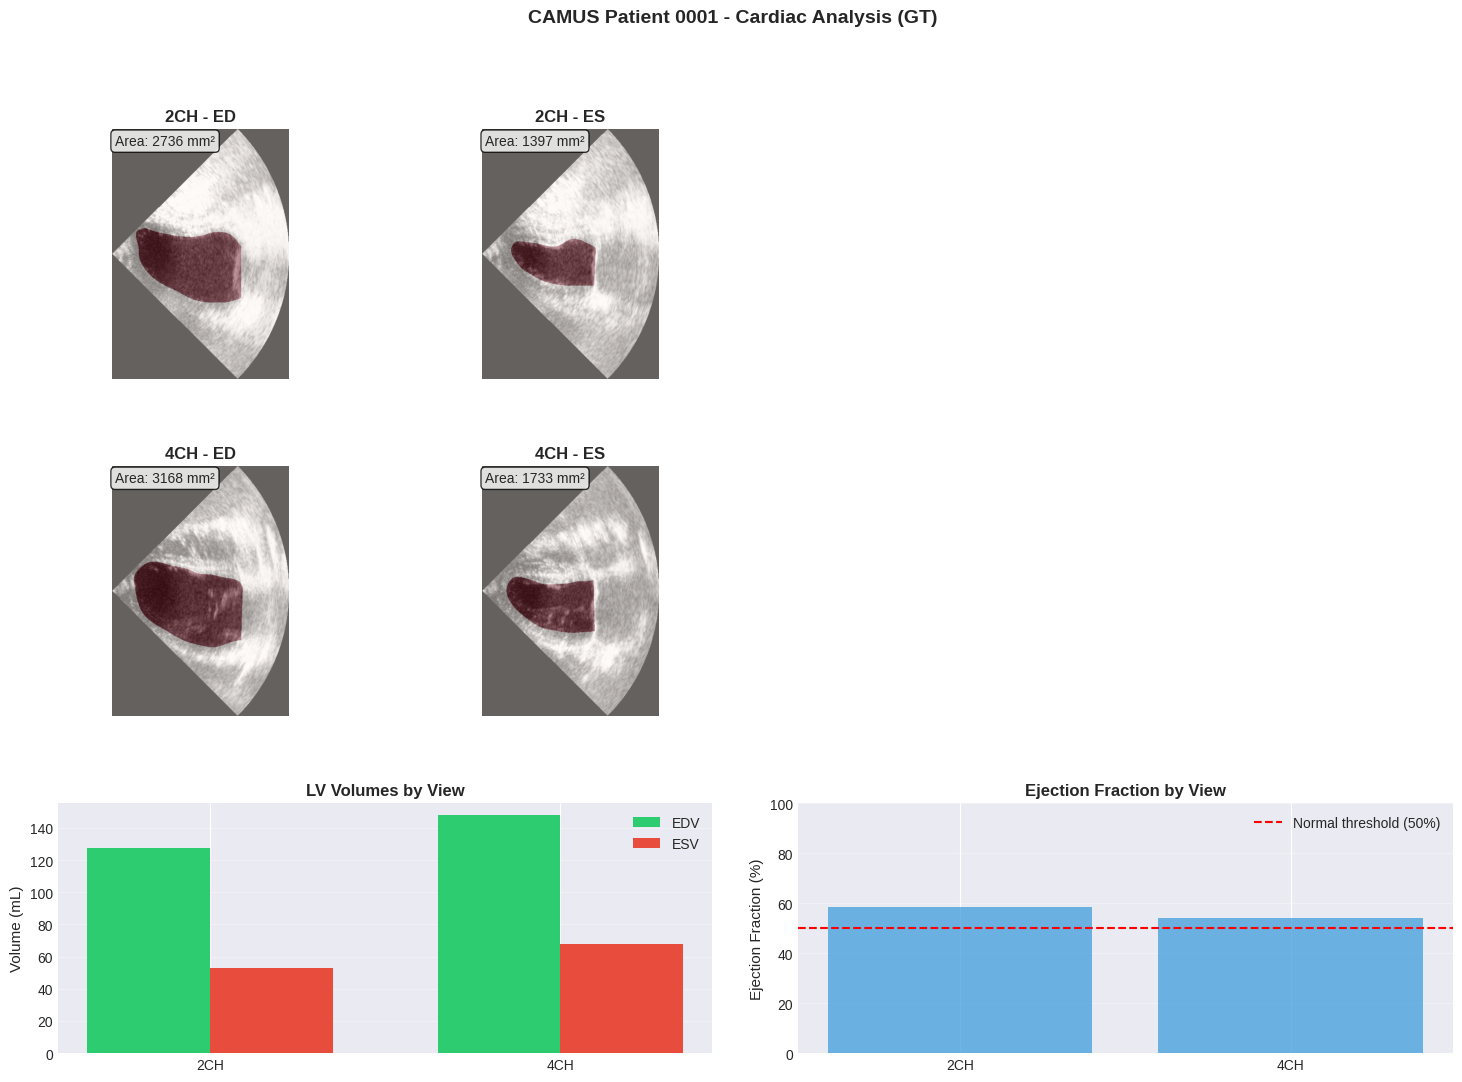


Patient 0001 - Quantitative Analysis Summary

2CH View:
  EDV: 127.3 mL
  ESV: 52.7 mL
  SV:  74.6 mL
  EF:  58.6 %

4CH View:
  EDV: 147.9 mL
  ESV: 67.8 mL
  SV:  80.1 mL
  EF:  54.2 %

Biplane Average:
  EDV: 137.6 mL
  ESV: 60.3 mL
  SV:  77.4 mL
  EF:  56.2 %




In [43]:
# Cell [13]
# ============================================================================
# RUN COMPLETE ANALYSIS
# ============================================================================

# Analyze patient 0001
visualize_camus_analysis("0001", source="gt")

Total patients available: 500
First 10 patients: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010']

ANALYZING FIRST 3 PATIENTS



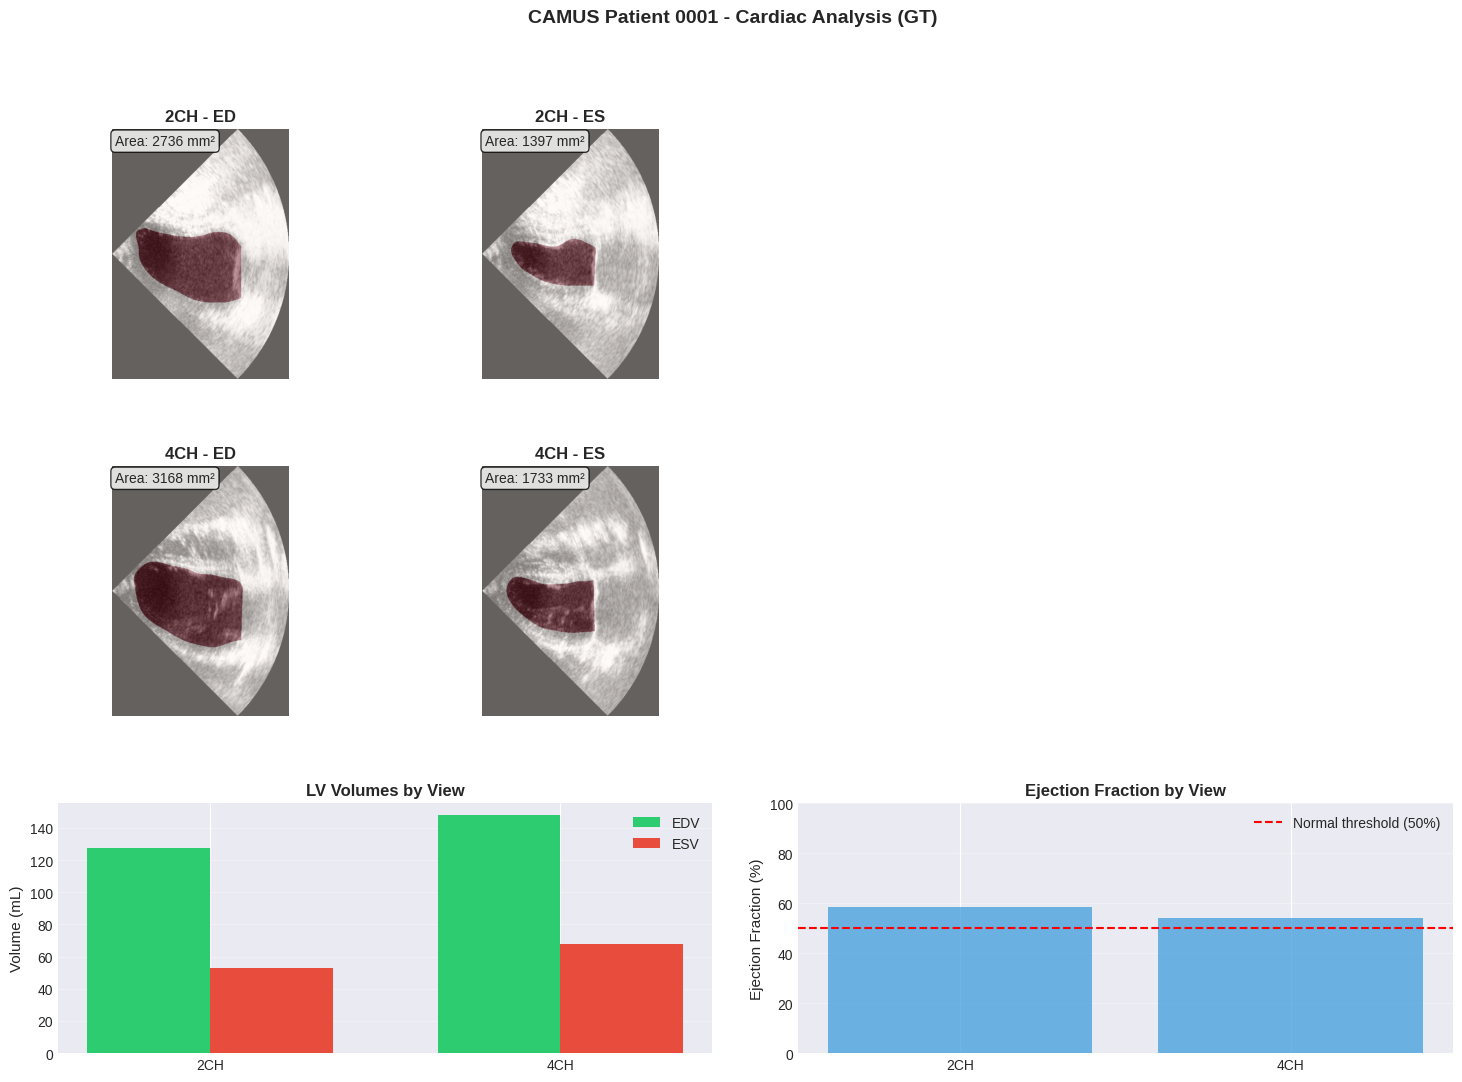


Patient 0001 - Quantitative Analysis Summary

2CH View:
  EDV: 127.3 mL
  ESV: 52.7 mL
  SV:  74.6 mL
  EF:  58.6 %

4CH View:
  EDV: 147.9 mL
  ESV: 67.8 mL
  SV:  80.1 mL
  EF:  54.2 %

Biplane Average:
  EDV: 137.6 mL
  ESV: 60.3 mL
  SV:  77.4 mL
  EF:  56.2 %




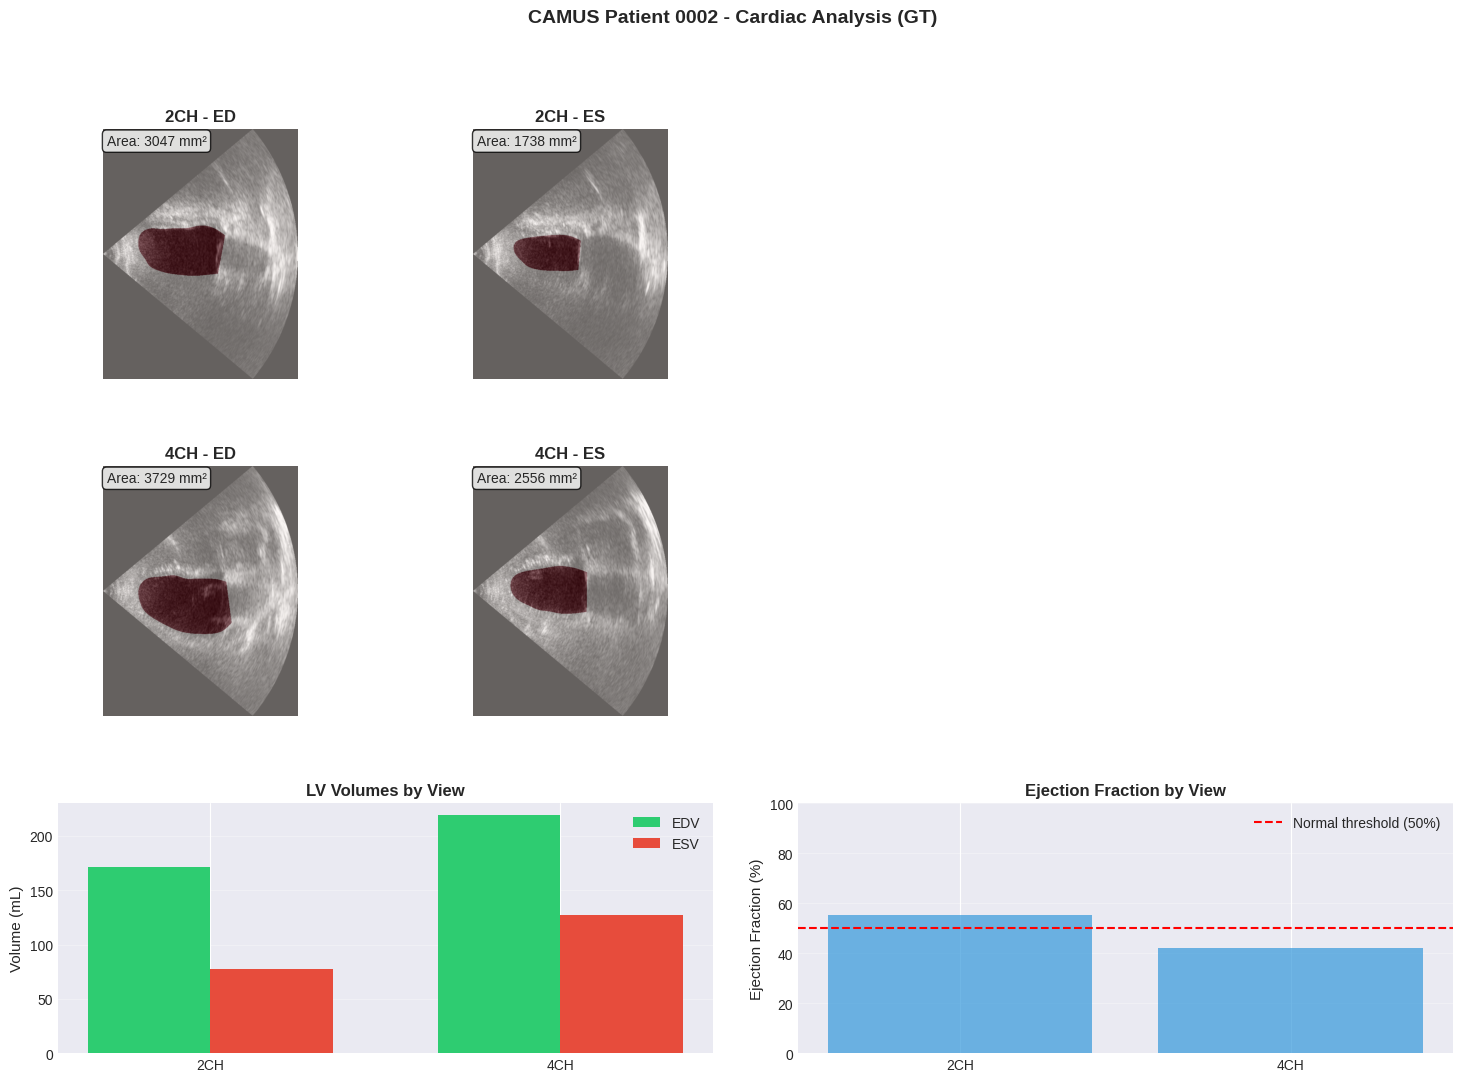


Patient 0002 - Quantitative Analysis Summary

2CH View:
  EDV: 171.7 mL
  ESV: 77.1 mL
  SV:  94.6 mL
  EF:  55.1 %

4CH View:
  EDV: 219.0 mL
  ESV: 126.8 mL
  SV:  92.2 mL
  EF:  42.1 %

Biplane Average:
  EDV: 195.4 mL
  ESV: 101.9 mL
  SV:  93.4 mL
  EF:  47.8 %




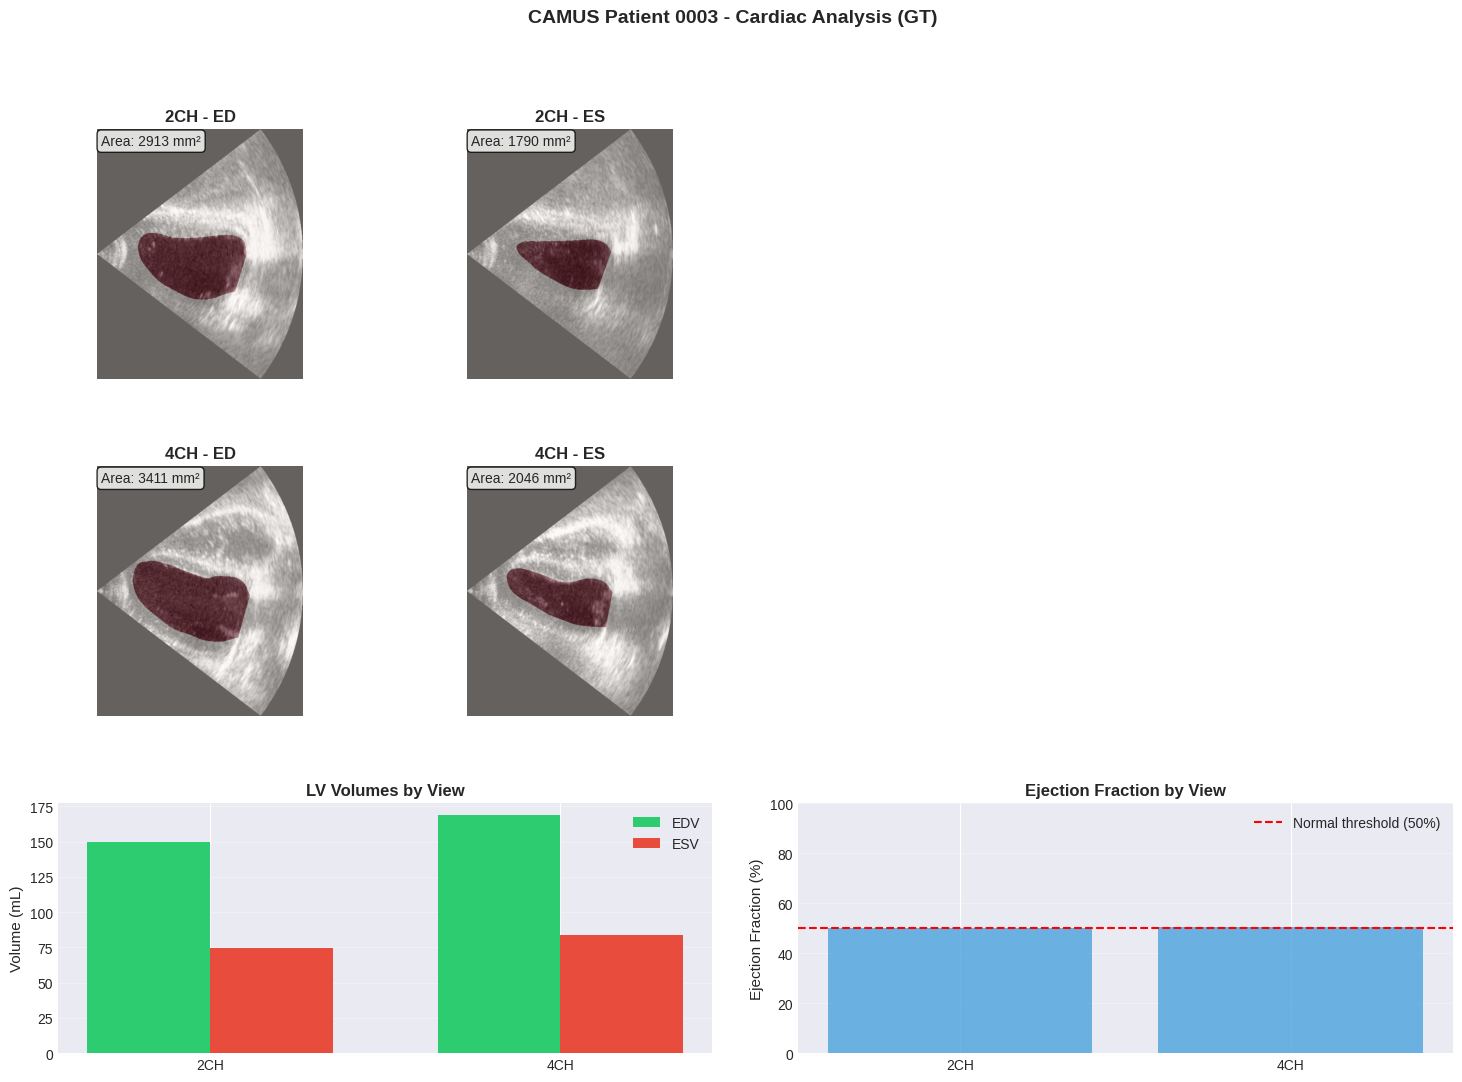


Patient 0003 - Quantitative Analysis Summary

2CH View:
  EDV: 149.9 mL
  ESV: 74.8 mL
  SV:  75.1 mL
  EF:  50.1 %

4CH View:
  EDV: 168.7 mL
  ESV: 83.6 mL
  SV:  85.1 mL
  EF:  50.4 %

Biplane Average:
  EDV: 159.3 mL
  ESV: 79.2 mL
  SV:  80.1 mL
  EF:  50.3 %




In [44]:
# Cell [14]
# ============================================================================
# BATCH ANALYSIS OF MULTIPLE PATIENTS
# ============================================================================

# Get list of available patients
patients = sorted([d.replace("patient", "") for d in os.listdir(CAMUS_ROOT) 
                   if d.startswith("patient")])

print(f"Total patients available: {len(patients)}")
print(f"First 10 patients: {patients[:10]}")

# Analyze first 3 patients
print("\n" + "="*60)
print("ANALYZING FIRST 3 PATIENTS")
print("="*60 + "\n")

for pid in patients[:3]:
    visualize_camus_analysis(pid, source="gt")


SUMMARY STATISTICS - 500 Patients

EDV: 155.1 ± 52.8 mL (range: 45.3 - 390.8)
ESV: 85.3 ± 42.3 mL (range: 20.1 - 345.5)
SV:  69.8 ± 23.2 mL (range: 19.2 - 165.7)
EF:  46.5 ± 11.4 % (range: 7.0 - 75.8)


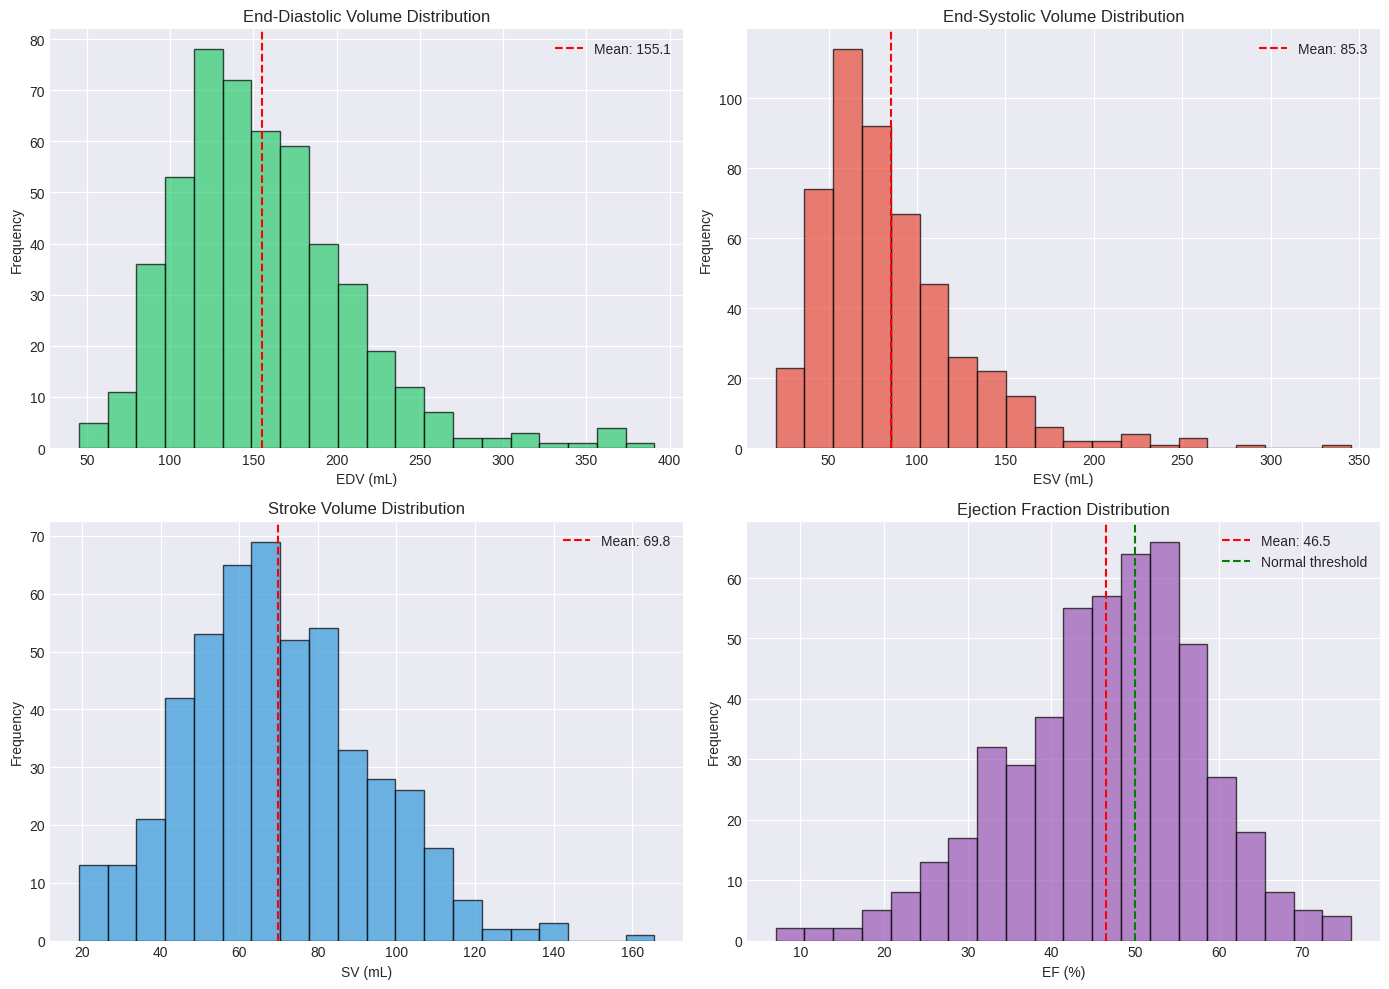

In [45]:
# Cell [15]
# ============================================================================
# SUMMARY STATISTICS ACROSS ALL PATIENTS
# ============================================================================

def analyze_all_patients(source="gt"):
    """Calculate summary statistics across all patients"""
    
    patients = sorted([d.replace("patient", "") for d in os.listdir(CAMUS_ROOT) 
                       if d.startswith("patient")])
    
    results = []
    
    for pid in patients:
        biplane = calculate_biplane_volumes(pid, source)
        if biplane:
            results.append({
                'patient_id': pid,
                'EDV': biplane['EDV'],
                'ESV': biplane['ESV'],
                'SV': biplane['SV'],
                'EF': biplane['EF']
            })
    
    # Convert to arrays for statistics
    edvs = [r['EDV'] for r in results]
    esvs = [r['ESV'] for r in results]
    svs = [r['SV'] for r in results]
    efs = [r['EF'] for r in results]
    
    print(f"\n{'='*60}")
    print(f"SUMMARY STATISTICS - {len(results)} Patients")
    print(f"{'='*60}\n")
    
    print(f"EDV: {np.mean(edvs):.1f} ± {np.std(edvs):.1f} mL (range: {np.min(edvs):.1f} - {np.max(edvs):.1f})")
    print(f"ESV: {np.mean(esvs):.1f} ± {np.std(esvs):.1f} mL (range: {np.min(esvs):.1f} - {np.max(esvs):.1f})")
    print(f"SV:  {np.mean(svs):.1f} ± {np.std(svs):.1f} mL (range: {np.min(svs):.1f} - {np.max(svs):.1f})")
    print(f"EF:  {np.mean(efs):.1f} ± {np.std(efs):.1f} % (range: {np.min(efs):.1f} - {np.max(efs):.1f})")
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].hist(edvs, bins=20, color='#2ecc71', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('EDV (mL)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('End-Diastolic Volume Distribution')
    axes[0, 0].axvline(np.mean(edvs), color='red', linestyle='--', label=f'Mean: {np.mean(edvs):.1f}')
    axes[0, 0].legend()
    
    axes[0, 1].hist(esvs, bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('ESV (mL)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('End-Systolic Volume Distribution')
    axes[0, 1].axvline(np.mean(esvs), color='red', linestyle='--', label=f'Mean: {np.mean(esvs):.1f}')
    axes[0, 1].legend()
    
    axes[1, 0].hist(svs, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('SV (mL)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Stroke Volume Distribution')
    axes[1, 0].axvline(np.mean(svs), color='red', linestyle='--', label=f'Mean: {np.mean(svs):.1f}')
    axes[1, 0].legend()
    
    axes[1, 1].hist(efs, bins=20, color='#9b59b6', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('EF (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Ejection Fraction Distribution')
    axes[1, 1].axvline(np.mean(efs), color='red', linestyle='--', label=f'Mean: {np.mean(efs):.1f}')
    axes[1, 1].axvline(50, color='green', linestyle='--', label='Normal threshold')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run the analysis
all_results = analyze_all_patients(source="gt")